In [2]:
#default_exp verbatims/standard_themes_meta/training

In [3]:
#all_slow

In [4]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard Meta Themes - Training

> This module contains all the bits required to train and evaluate meta standard theme models.  These are models which, for a given verbatim related to a standard tehem, predicts the sentiment relative to *that* theme and whether it should be used as an example

In [5]:
#export
import os, datetime, gc
import sklearn.metrics as skm

import optuna

from fastai import metrics as fa_metrics
from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.all import MultiTargetLoss
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [6]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [7]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [8]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


In [9]:
train_config = {}

## Data

In [9]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = 'facebook/bart-base' #"bert-base-cased" #"bert-base-uncased" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.attention_probs_dropout_prob = 0.1 * 2
config.hidden_dropout_prob = 0.1 * 2

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [10]:
df = get_meta_standard_theme_train_data(train_config=train_config)
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

set_seed(TL_RAND_SEED)
dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=train_config)

In [11]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape, b[2].shape

(3, torch.Size([8, 468]), torch.Size([8]), torch.Size([8]))

## Training

In [12]:
m_pre = f'exp_{m_pre_standard_themes_meta}'
m_suf = m_suf_standard_themes_meta
base_model_name = base_model_name_standard_themes_meta

Configure our **metrics**

In [9]:
#export
# define metrics
def sentiment_mse(preds, *targs):
    return fa_metrics.mse(preds[0], targs[0])

def is_example_acc(preds, *targs):
    return fa_metrics.accuracy(preds[1], targs[1])

In [10]:
#export
def get_metrics(train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}
    return [ sentiment_mse, is_example_acc ]

Configure our **loss**

In [15]:
is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
print(is_example_weights)

[1.0, 148.02469135802468]


In [16]:
# define our custom multi-target loss
loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                            loss_classes_kwargs=[{}, {'weight': FloatTensor(is_example_weights).to('cuda:1')}],
                            weights=[1, 0.1], 
                            reduction='mean')

In [11]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    loss_classes_kwargs = [{}, {}]
    
    if (use_weighted and train_df is not None):
        is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
        loss_classes_kwargs[1] = {'weight': FloatTensor(is_example_weights).to(dls.device)}
    
    loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                                loss_classes_kwargs=loss_classes_kwargs,
                                weights=[1, 0.1], 
                                reduction='mean')
        
    return loss_func

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), MultiTargetLoss)

In [19]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), MultiTargetLoss)
test_eq(len(tst_loss_func.loss_funcs[1].func.weight), len(dls.c))
test_eq(dls.device, tst_loss_func.loss_funcs[1].func.weight.device)

Configure our **callbacks**

In [12]:
#export
class Meta_MM_HF_BaseModelCallback(HF_BaseModelCallback):
    def __init__(self, cls_idx=0):
        super().__init__()
        self.cls_idx = cls_idx
        
    def after_pred(self):
        super().after_pred()
        if (self.learn.pred[0].dim() == 3):
            self.learn.pred = (self.learn.pred[0][:,self.cls_idx,:], self.learn.pred[1][:,self.cls_idx,:])

In [21]:
best_model_cb = SaveModelCallback(monitor='valid_loss', 
                                  comp=np.less, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}{base_model_name}{m_suf}_bestmodel')

In [13]:
#export
def get_cbs(train_config={}, add_save_model_cb=True):
    config = {**meta_standard_themes_train_config, **train_config}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    
    return [Meta_MM_HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **final model** by updating our hf_model.classifier for multi-modal tasks

In [23]:
#hide

# class Meta_MM(Module):
#     def __init__(self, in_features=768, inner_dim=768, p=0.0): 
#         super().__init__()
#         self.dense = nn.Linear(in_features, inner_dim)
#         self.dropout = nn.Dropout(p=p)
#         self.pred_is_example = nn.Linear(inner_dim, 2, bias=False)
#         self.pred_avg_sentiment = nn.Linear(inner_dim, 1, bias=False)
#         self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
#     def forward(self, x):
#         x = self.dropout(x)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         is_example = self.pred_is_example(x)
#         avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
#         return avg_sentiment, is_example

In [14]:
#export
class Meta_MM(Module):
    def __init__(self, in_features=50): 
        super().__init__()
        self.pred_is_example = nn.Linear(in_features, 2, bias=False)
        self.pred_avg_sentiment = nn.Linear(in_features, 1, bias=False)
        self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
    def forward(self, x):
        is_example = self.pred_is_example(x)
        avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
        return avg_sentiment, is_example

In [25]:
last_layer = list(hf_model.named_children())[-1]

In [26]:
last_layer_name = last_layer[0]; last_layer_name

'classification_head'

In [27]:
in_features = hf_model._modules[last_layer_name].dense.in_features

In [28]:
hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)

In [29]:
#hide
# in_features = list(last_layer[1].children())[0].in_features; in_features
# mm_model = nn.Sequential(list(hf_model.named_children())[:-1][0][1])
# mm_model.add_module(name='classifier', module=MM(in_features=768))
# hf_model._modules['classifier'] = hf_model._modules.pop(last_layer_name)

Configure the **Learner**

In [30]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [31]:
learn_metrics = [sentiment_mse, is_example_acc]

learn_cbs = [Meta_MM_HF_BaseModelCallback]
fit_cbs = [best_model_cb]

# build learner
model =HF_BaseModelWrapper(hf_model)

set_seed(TL_RAND_SEED)
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_META_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [32]:
# learn.blurr_summary()

In [33]:
# learn.show_training_loop()

In [34]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0][0].shape, preds[0][1].shape

In [15]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                add_save_model_cb=True, train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}
    
    # swap out classifier for our Meta_MM module
    last_layer = list(hf_model.named_children())[-1]
    last_layer_name = last_layer[0]
    in_features = hf_model._modules[last_layer_name].dense.in_features
    hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(9.999999747378752e-07, 1.3182567499825382e-06)

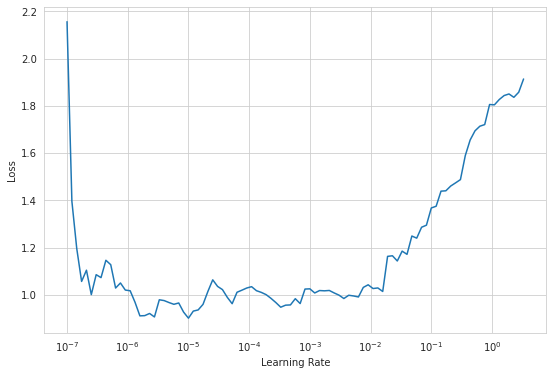

In [36]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [37]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(1, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,0.929812,0.943785,0.908603,0.981888,02:05


Better model found at epoch 0 with valid_loss value: 0.9437850117683411.


(1.0964781722577755e-07, 9.12010818865383e-07)

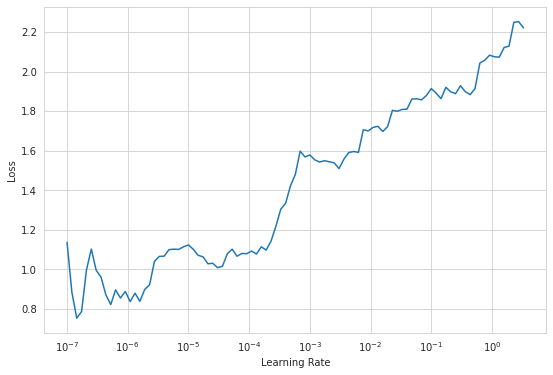

In [38]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [39]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,0.911631,0.918890,0.884714,0.984747,03:44
1,0.978143,0.841289,0.810555,0.991420,03:45
2,0.804809,0.775611,0.748013,0.991420,03:46
3,0.744287,0.729382,0.703372,0.991420,03:48
4,0.795165,0.693655,0.668524,0.991420,03:47
5,0.702241,0.668064,0.643372,0.991420,03:47
6,0.710689,0.651300,0.626834,0.991420,03:48
7,0.721196,0.643052,0.618704,0.991420,03:48
8,0.695299,0.640770,0.616453,0.991420,03:47
9,0.655520,0.640692,0.616377,0.991420,03:47


Better model found at epoch 0 with valid_loss value: 0.9188904166221619.
Better model found at epoch 1 with valid_loss value: 0.8412891030311584.
Better model found at epoch 2 with valid_loss value: 0.7756107449531555.
Better model found at epoch 3 with valid_loss value: 0.7293819189071655.
Better model found at epoch 4 with valid_loss value: 0.6936553716659546.
Better model found at epoch 5 with valid_loss value: 0.668064296245575.
Better model found at epoch 6 with valid_loss value: 0.6512995958328247.
Better model found at epoch 7 with valid_loss value: 0.6430519223213196.
Better model found at epoch 8 with valid_loss value: 0.6407696604728699.
Better model found at epoch 9 with valid_loss value: 0.6406921148300171.


In [40]:
learn.save(f'{m_pre}{base_model_name}{m_suf}')

Path('data/classification/standard_themes/meta/models/exp_verbatim_standard_theme_meta_multitask_hf.pth')

Export model for inference

In [41]:
learn.export(fname=f'{m_pre}{base_model_name}{m_suf}_export.pkl')

Look at results

In [42]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.6406921148300171,
 'sentiment_mse': 0.6163774132728577,
 'is_example_acc': 0.9914203882217407}

In [43]:
learn.show_results(learner=learn, max_n=2) 

,text,text_,category,target1,target2
0,"theme: Have Voice within my Institution/Valued Member of my Institution comment: Staff no longer receive COLAs, like the faculty do--we are instead told that our COLA is a merit increase and expected to believe this.\r\n\r\nThis is incredibly demoralizing and many talented staff with institutional longevity are considered leaving UCSD for higher compensation elsewhere, at least as far as I am able to report by personal conversation. The turnover loss to the department if this were to happen would be substantial. Experienced career staff have knowledge that they can generalize from to solve the unique problems that arise frequently in the university setting. New staff cannot always provide these solutions to faculty.\r\n\r\nFurther our'merit increases' were not announced in a timely manner and apparently do not include July, that is, they are effective Aug 1. I do not think our faculty would accept this! It is true that the faculty attract fee-paying students to campus but the institution truly is a three legged stool--charitably I do not think our department could be run with faculty alone.\r\n\r\nAsides from compensation, which is an UCOP / EVCAA issue, Mathematics is a good department to work. \r\n\r\nThe MSO (which I am not) should receive more credit for proactive solutions to pending / future problems but since these problems do not materialize when solved it is not often that the faculty recognize this.\r\n\r\nSupervisors are generally good. \r\n\r\nThis department has lots of room for growth and additionally a significant amount of room for process improvement in many domain areas.",3.0,0,"(2.3660523891448975,)",0
1,"theme: Have Voice within my Institution/Valued Member of my Institution comment: My team colleagues frequently gossip, talk, laugh around me (and I can hear them). They also frequently withhold information necessary for team work and for me to successfully do my job. They also complain their work which furthers a negative environment. This team is oriented towards dysfunctional individuals, not on the team or service for customers. This has caused problem with anxiety and insomnia which has been very difficult for me. I've had to spend a lot of time personally taking care of myself to offset the negative impact this has created. I am a service oriented, transparent individual and pride myself on treating others with kindness regardless of their position.\r\n\r\nOccasionally I've had mobility issues and brought ADA compliance issues to team members' attention like no elevator access due to a mechanical issue and the only option was climbing 3 flights of stairs one way. Instead of this being addressed as an ADA issued, I was targeted spoken to with increased volume and told I could call Facilities Management myself if I didn't like the response or blown off like I was un-useful because I couldn't assist with a request requiring mobility when this is not an issue caused by me. This is completely unacceptable. \r\n\r\nAlthough I am not old, I've also experienced ageism because I have senior level experience in position. I've also been mocked by 2 colleges because I'm a grandparent. This is completely unacceptable. This survey does not include age discrimination.",1.0,0,"(2.1806387901306152,)",0


Use it for inference

In [44]:
inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')

In [45]:
inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible')

(((2.4098987579345703), '0'), tensor([[2.4099]]), tensor([[2.4099]]))

Review final validation loss for best model

In [46]:
learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.9456282258033752


In [47]:
for prob_sent, prob_example, targ_sent, targ_example in zip(*probs,*targs):
    print(prob_sent, targ_sent, torch.argmax(prob_example, dim=-1), targ_example)

tensor([2.3317]) tensor(2.) tensor(0) tensor(0)
tensor([1.9597]) tensor(2.) tensor(0) tensor(0)
tensor([2.1157]) tensor(2.) tensor(0) tensor(0)
tensor([2.4783]) tensor(2.) tensor(0) tensor(0)
tensor([2.3356]) tensor(2.) tensor(0) tensor(0)
tensor([2.2869]) tensor(2.) tensor(0) tensor(0)
tensor([2.3826]) tensor(2.) tensor(0) tensor(0)
tensor([2.3202]) tensor(3.) tensor(0) tensor(0)
tensor([2.4539]) tensor(2.) tensor(0) tensor(0)
tensor([3.0743]) tensor(3.) tensor(0) tensor(0)
tensor([2.2604]) tensor(3.) tensor(0) tensor(0)
tensor([2.4032]) tensor(3.) tensor(0) tensor(0)
tensor([2.0880]) tensor(2.) tensor(0) tensor(0)
tensor([2.3007]) tensor(3.) tensor(0) tensor(0)
tensor([2.0287]) tensor(2.) tensor(0) tensor(0)
tensor([1.9187]) tensor(4.5000) tensor(0) tensor(0)
tensor([2.8316]) tensor(2.) tensor(0) tensor(0)
tensor([2.4760]) tensor(2.) tensor(0) tensor(0)
tensor([2.4113]) tensor(2.) tensor(0) tensor(0)
tensor([2.5720]) tensor(3.) tensor(0) tensor(0)
tensor([2.4291]) tensor(2.) tensor(0

tensor([2.2611]) tensor(1.) tensor(0) tensor(0)
tensor([2.2810]) tensor(1.) tensor(0) tensor(0)
tensor([2.1253]) tensor(2.) tensor(0) tensor(0)
tensor([2.6276]) tensor(2.) tensor(0) tensor(0)
tensor([2.1111]) tensor(4.) tensor(0) tensor(0)
tensor([2.2938]) tensor(2.) tensor(0) tensor(0)
tensor([2.1013]) tensor(3.) tensor(0) tensor(0)
tensor([2.8457]) tensor(2.) tensor(0) tensor(0)
tensor([1.8007]) tensor(2.) tensor(0) tensor(0)
tensor([3.4261]) tensor(5.) tensor(0) tensor(0)
tensor([2.7473]) tensor(3.) tensor(0) tensor(0)
tensor([2.8915]) tensor(4.) tensor(0) tensor(0)
tensor([2.4613]) tensor(3.) tensor(0) tensor(0)
tensor([1.9193]) tensor(3.) tensor(0) tensor(0)
tensor([3.1941]) tensor(5.) tensor(0) tensor(0)
tensor([2.9374]) tensor(3.) tensor(0) tensor(0)
tensor([2.3709]) tensor(2.) tensor(0) tensor(0)
tensor([2.7377]) tensor(3.) tensor(0) tensor(0)
tensor([1.7756]) tensor(1.) tensor(0) tensor(0)
tensor([2.5674]) tensor(3.) tensor(0) tensor(0)
tensor([2.0624]) tensor(1.) tensor(0) te

tensor([2.1517]) tensor(2.) tensor(0) tensor(0)
tensor([2.3853]) tensor(2.) tensor(0) tensor(0)
tensor([2.8793]) tensor(2.) tensor(0) tensor(0)
tensor([1.9415]) tensor(1.) tensor(0) tensor(0)
tensor([2.5673]) tensor(3.) tensor(0) tensor(0)
tensor([2.9706]) tensor(2.5000) tensor(0) tensor(0)
tensor([2.1851]) tensor(3.) tensor(0) tensor(0)
tensor([2.8777]) tensor(2.) tensor(0) tensor(0)
tensor([1.8124]) tensor(2.) tensor(0) tensor(0)
tensor([1.9635]) tensor(2.) tensor(0) tensor(0)
tensor([2.2016]) tensor(2.) tensor(0) tensor(0)
tensor([2.3320]) tensor(2.) tensor(0) tensor(0)
tensor([1.9803]) tensor(3.) tensor(0) tensor(0)
tensor([2.4295]) tensor(3.) tensor(0) tensor(0)
tensor([2.4070]) tensor(3.) tensor(0) tensor(0)
tensor([2.4788]) tensor(3.) tensor(0) tensor(0)
tensor([1.9780]) tensor(3.) tensor(0) tensor(0)
tensor([2.1912]) tensor(2.) tensor(0) tensor(0)
tensor([1.8525]) tensor(2.) tensor(0) tensor(0)
tensor([2.3454]) tensor(3.) tensor(0) tensor(0)
tensor([2.7161]) tensor(4.) tensor(0

tensor([1.9452]) tensor(2.) tensor(0) tensor(0)
tensor([3.3235]) tensor(3.) tensor(0) tensor(0)
tensor([2.5567]) tensor(2.) tensor(0) tensor(0)
tensor([2.2000]) tensor(2.) tensor(0) tensor(0)
tensor([2.4249]) tensor(2.) tensor(0) tensor(0)
tensor([2.1752]) tensor(3.) tensor(0) tensor(0)
tensor([2.9505]) tensor(2.) tensor(0) tensor(0)
tensor([2.1278]) tensor(2.) tensor(0) tensor(0)
tensor([2.3028]) tensor(2.) tensor(0) tensor(0)
tensor([1.8414]) tensor(3.) tensor(0) tensor(0)
tensor([1.8395]) tensor(2.) tensor(0) tensor(0)
tensor([2.9722]) tensor(4.) tensor(0) tensor(0)
tensor([2.0643]) tensor(2.) tensor(0) tensor(0)
tensor([3.0356]) tensor(5.) tensor(0) tensor(0)
tensor([2.0989]) tensor(3.) tensor(0) tensor(0)
tensor([2.6866]) tensor(3.) tensor(0) tensor(0)
tensor([2.5287]) tensor(3.) tensor(0) tensor(0)
tensor([2.6104]) tensor(3.) tensor(0) tensor(0)
tensor([3.2854]) tensor(3.) tensor(0) tensor(0)
tensor([2.3993]) tensor(1.) tensor(0) tensor(0)
tensor([2.7755]) tensor(3.) tensor(0) te

tensor([2.0866]) tensor(2.) tensor(0) tensor(0)
tensor([2.4637]) tensor(2.) tensor(0) tensor(0)
tensor([2.5325]) tensor(3.) tensor(0) tensor(0)
tensor([2.3414]) tensor(2.) tensor(0) tensor(0)
tensor([2.1559]) tensor(2.) tensor(0) tensor(0)
tensor([3.0532]) tensor(5.) tensor(0) tensor(0)
tensor([2.1589]) tensor(1.) tensor(0) tensor(0)
tensor([2.3712]) tensor(2.) tensor(0) tensor(0)
tensor([2.4159]) tensor(2.) tensor(0) tensor(0)
tensor([3.0382]) tensor(2.) tensor(0) tensor(0)
tensor([2.6093]) tensor(4.) tensor(0) tensor(0)
tensor([2.5619]) tensor(2.) tensor(0) tensor(0)
tensor([2.3124]) tensor(3.) tensor(0) tensor(0)
tensor([2.0492]) tensor(2.) tensor(0) tensor(0)
tensor([2.0245]) tensor(2.) tensor(0) tensor(0)
tensor([2.5384]) tensor(2.) tensor(0) tensor(0)
tensor([2.5946]) tensor(2.) tensor(0) tensor(0)
tensor([2.8453]) tensor(2.) tensor(0) tensor(0)
tensor([2.5471]) tensor(1.) tensor(0) tensor(0)
tensor([2.4035]) tensor(3.) tensor(0) tensor(0)
tensor([3.0961]) tensor(3.) tensor(0) te

In [48]:
STANDARD_THEME_SAW_LABELS[:5]

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions']

In [49]:
learn.blurr_predict("theme: Adequate Staffing comment: We don't have enough people to get the job done.")

(((2.6881637573242188), '0'), tensor([[2.6882]]), tensor([[2.6882]]))

## Review

In [50]:
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [51]:
# predictions for a single model using the learner's model and data loaders
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = 'facebook/bart-base' #"bert-base-cased" #"bert-base-uncased" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.attention_probs_dropout_prob = 0.1 * 2
config.hidden_dropout_prob = 0.1 * 2

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config={})

learn = learn.load(f'{m_pre}{base_model_name}{m_suf}_bestmodel')
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs[0].shape, probs[1].shape, targs[0].shape, targs[1].shape

(torch.Size([1049, 1]),
 torch.Size([1049, 2]),
 torch.Size([1049]),
 torch.Size([1049]))

### Lets look at validation metrics

In [52]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
# is_example_prob_true

In [53]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)

In [54]:
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

threshold_f05, threshold_f1, threshold_f2

(0.29000000000000004, 0.29000000000000004, 0.29000000000000004)

In [55]:
f05_score = f05.opt_fscore(is_example_prob_true, targs[1])
f1_score = f1.opt_fscore(is_example_prob_true, targs[1])
f2_score = f2.opt_fscore(is_example_prob_true, targs[1])

f05_score, f1_score, f2_score

(0.011180124223602485, 0.017769002961500496, 0.043269230769230775)

In [56]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs[1], (is_example_prob_true > threshold_f05), beta=.5, 
                      average='binary', sample_weight=None, zero_division=False)
res

0.011180124223602485

In [57]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9914203882217407, 0.9914203882217407, 0.9914203882217407)

In [58]:
# make sure we are getting the same f1 accuracy
preds = ((is_example_prob_true > threshold_f05).byte() == targs[1].byte()).float().mean()
preds.item()

0.051477596163749695

### Overall metrics - is_example_prob_true

In [59]:
eval_targs = targs[1].flatten() # targs[:,0]
eval_probs = is_example_prob_true.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [60]:
print(skm.accuracy_score(eval_targs, (is_example_prob_true > threshold_f05).float(), sample_weight=None))

0.05147759771210677


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [61]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0 1040


In [62]:
most_freq_class_count / len(eval_targs)

0.9914204003813155

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [63]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=None))

0.0007754424090410383


#### Confusion Matrix

Describes the performance of a classification model

In [64]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [65]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=None)

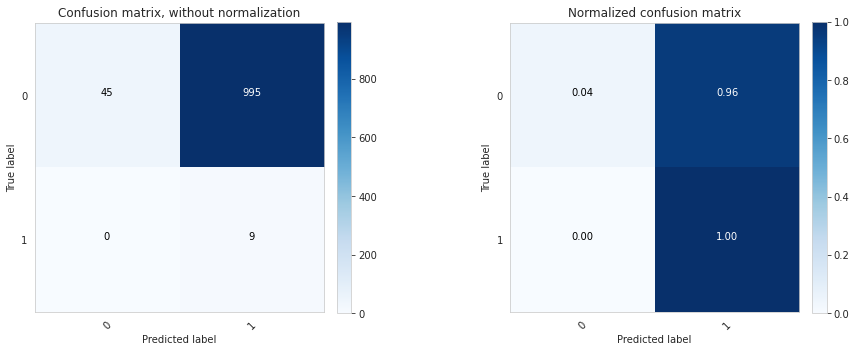

In [66]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [67]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=None, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1040
           1       0.01      1.00      0.02         9

    accuracy                           0.05      1049
   macro avg       0.50      0.52      0.05      1049
weighted avg       0.99      0.05      0.08      1049



#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

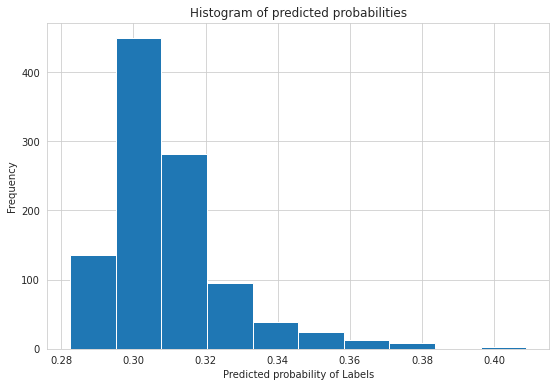

In [68]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [69]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=None)

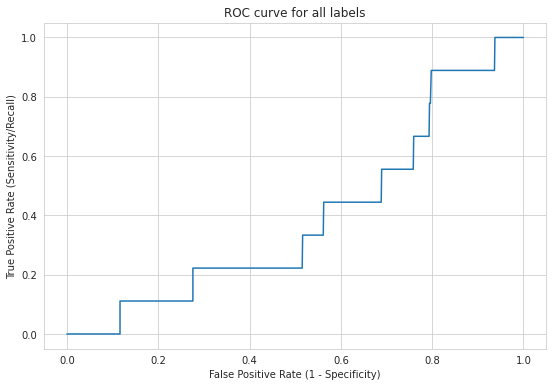

In [70]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [71]:
print(skm.roc_auc_score(eval_targs, eval_probs, average='weighted', sample_weight=None))

0.3948717948717949


### Overall metrics - is_example_prob_true

In [72]:
# mse
skm.mean_squared_error(targs[0], probs[0])

0.62583274

In [73]:
# rmse
math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

0.7910959085295265

In [74]:
# mae
skm.mean_absolute_error(targs[0], probs[0])

0.6270062

## Final results

In [75]:
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{m_pre}{base_model_name}{m_suf}_export.pkl')
inf_learn.loss_func.loss_funcs[1].func.weight = inf_learn.loss_func.loss_funcs[1].func.weight.to(dls.device)
dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [76]:
probs, targs, losses = inf_learn.get_preds(with_loss=True, reorder=True)

In [77]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)

In [78]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]

In [79]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true, targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true, targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true, targs[1], threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(is_example_prob_true, targs[1], sigmoid=False)}')

0.29000000000000004 0.29000000000000004 0.29000000000000004
Fowards Only
-------------
f05:	Optimal threshold = 0.29000000000000004	(Accuracy = 0.061010487377643585)
f1:	Optimal threshold = 0.29000000000000004	(Accuracy = 0.061010487377643585)
f2:	Optimal threshold = 0.29000000000000004	(Accuracy = 0.061010487377643585)

Accuracy: 0.9914203882217407


In [80]:
mae = skm.mean_absolute_error(targs[0], probs[0])
mse = skm.mean_squared_error(targs[0], probs[0])
rmse = math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

mae, mse, rmse

(0.6238375, 0.61637735, 0.7850970345557375)

In [81]:
final_valid_loss = losses.mean().item(); final_valid_loss

0.9456282258033752

## Build our training loop for hyperparam optimization and final training

In [16]:
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()
    
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [17]:
class FastAIPruningCallbackv2(TrackerCallback):
    def __init__(self, trial, monitor='valid_loss', **kwargs) -> None:
        super().__init__(monitor=monitor, **kwargs)
        self._trial = trial

    def after_epoch(self) -> None:
        super().after_epoch()
        
        value = self.recorder.values[-1][self.idx]
        if value is None: return

        self._trial.report(float(value), step=self.epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(self.epoch)
            raise optuna.TrialPruned(message)

In [18]:
#export
def train(params, trial=None, train_config={}):
          
    config = {**meta_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])

    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)
    
    # 2. build our dls and learner
    df = get_meta_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
        scores['is_example_f05'], scores['is_example_f1'], scores['is_example_f2'] = {}, {}, {}

        scores['is_example_f05']['threshold'] = f05.opt_th(is_example_prob_true, targs[1])
        scores['is_example_f1']['threshold'] = f1.opt_th(is_example_prob_true, targs[1])
        scores['is_example_f2']['threshold'] = f2.opt_th(is_example_prob_true, targs[1])

        scores['is_example_f05']['score'] = f05.opt_fscore(is_example_prob_true, targs[1])
        scores['is_example_f1']['score'] = f1.opt_fscore(is_example_prob_true, targs[1])
        scores['is_example_f2']['score'] = f2.opt_fscore(is_example_prob_true, targs[1])

        scores['sentiment'] = {
            'mae': skm.mean_absolute_error(targs[0], probs[0]).item(),
            'mse': skm.mean_squared_error(targs[0], probs[0]).item(),
            'rmse': math.sqrt(skm.mean_squared_error(targs[0], probs[0]).item())
        }
        
        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)
        
        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
        is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]

        probs_df = pd.DataFrame(np.concatenate((probs[0].numpy(), is_example_prob_true[:,None]), axis=-1), 
                                columns=['pred_sentiment', 'prob_is_example'])
        targs_df = pd.DataFrame(np.concatenate((targs[0].numpy()[:,None], targs[1].numpy()[:,None]), axis=-1), 
                                columns= ['targ_sentiment', 'targ_is_example'])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [19]:
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [20]:
#export
def objective(trial, train_config={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [True, False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 3),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 10),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 1e-7, 1e-6),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 1e-7, 1e-6),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 1e-9, 1e-7),
        'optimize_for': 'valid_loss',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, train_config=train_config)
    return score

In [21]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)

train_config = {}
study.optimize(partial(objective, train_config=train_config), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2020-10-24 14:30:18,915] A new study created in memory with name: no-name-266e576d-2864-4abb-a372-460765a7d15b


[I 2020-10-24 15:06:08,327] Trial 0 finished with value: 0.8463168144226074 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 3, 'n_unfrozen_epochs': 4, 'frozen_lr': 9.608787525580437e-07, 'unfrozen_lr_max': 1.5176809730352162e-07, 'unfrozen_lr_min': 2.1603317617807016e-09, 'activation_dropout': 0.05, 'attention_dropout': 0.25, 'classif_dropout': 0.1, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.05}. Best is trial 0 with value: 0.8463168144226074.


[I 2020-10-24 16:15:19,368] Trial 1 finished with value: 0.8286561369895935 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 10, 'frozen_lr': 1.037154980319414e-07, 'unfrozen_lr_max': 3.3728652659690133e-07, 'unfrozen_lr_min': 1.7036045413727217e-09, 'activation_dropout': 0.1, 'attention_dropout': 0.05, 'classif_dropout': 0.15000000000000002, 'dropout': 0.25, 'attention_probs_dropout_prob': 0.1, 'hidden_dropout_prob': 0.2}. Best is trial 1 with value: 0.8286561369895935.


[I 2020-10-24 17:21:11,279] Trial 2 finished with value: 0.5142017006874084 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 10, 'frozen_lr': 2.8975082862096726e-07, 'unfrozen_lr_max': 6.047836536557682e-07, 'unfrozen_lr_min': 8.352912294717834e-09, 'activation_dropout': 0.05, 'attention_dropout': 0.25, 'classif_dropout': 0.05, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.05}. Best is trial 2 with value: 0.5142017006874084.


[I 2020-10-24 18:05:37,329] Trial 3 finished with value: 0.7450684309005737 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 6, 'frozen_lr': 1.3036298035395868e-07, 'unfrozen_lr_max': 4.5649242542479813e-07, 'unfrozen_lr_min': 2.0418090525359005e-09, 'activation_dropout': 0.05, 'attention_dropout': 0.2, 'classif_dropout': 0.2, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.05}. Best is trial 2 with value: 0.5142017006874084.


Better model found at epoch 0 with valid_loss value: 1.0800162553787231.


Better model found at epoch 0 with valid_loss value: 1.040364384651184.
Better model found at epoch 1 with valid_loss value: 0.9689270853996277.
Better model found at epoch 2 with valid_loss value: 0.9109830856323242.
Better model found at epoch 3 with valid_loss value: 0.8772831559181213.
Better model found at epoch 4 with valid_loss value: 0.8545389175415039.
Better model found at epoch 5 with valid_loss value: 0.8443712592124939.
Better model found at epoch 6 with valid_loss value: 0.8385421633720398.
Better model found at epoch 7 with valid_loss value: 0.8384924530982971.


[I 2020-10-24 18:59:15,870] Trial 4 finished with value: 0.8384924530982971 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 8, 'frozen_lr': 5.932025964460386e-07, 'unfrozen_lr_max': 1.1597602061403688e-07, 'unfrozen_lr_min': 1.5523029535853615e-08, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.05, 'classif_dropout': 0.15000000000000002, 'dropout': 0.2, 'attention_probs_dropout_prob': 0.3, 'hidden_dropout_prob': 0.05}. Best is trial 2 with value: 0.5142017006874084.


[I 2020-10-24 19:03:05,033] Trial 5 pruned. Trial was pruned at epoch 0.


Better model found at epoch 0 with valid_loss value: 1.0700973272323608.


[I 2020-10-24 19:10:21,663] Trial 6 pruned. Trial was pruned at epoch 1.


[I 2020-10-24 19:14:08,472] Trial 7 pruned. Trial was pruned at epoch 0.


Better model found at epoch 0 with valid_loss value: 1.0755170583724976.


[I 2020-10-24 19:21:19,823] Trial 8 pruned. Trial was pruned at epoch 1.


[I 2020-10-24 19:25:08,519] Trial 9 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 19:28:54,848] Trial 10 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 19:32:44,380] Trial 11 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 19:36:33,040] Trial 12 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 19:43:42,695] Trial 13 pruned. Trial was pruned at epoch 1.


[I 2020-10-24 19:47:29,863] Trial 14 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 19:51:18,386] Trial 15 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 20:13:48,393] Trial 16 finished with value: 0.7891263365745544 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 3, 'frozen_lr': 3.832521670248291e-07, 'unfrozen_lr_max': 9.794250031931575e-07, 'unfrozen_lr_min': 1.0381649907231264e-09, 'activation_dropout': 0.05, 'attention_dropout': 0.2, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.15000000000000002}. Best is trial 2 with value: 0.5142017006874084.


[I 2020-10-24 20:17:38,173] Trial 17 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 20:24:43,591] Trial 18 pruned. Trial was pruned at epoch 1.


[I 2020-10-24 21:23:57,044] Trial 19 finished with value: 0.48531827330589294 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 9, 'frozen_lr': 3.59035624977803e-07, 'unfrozen_lr_max': 4.536997497390868e-07, 'unfrozen_lr_min': 3.319391395922754e-08, 'activation_dropout': 0.1, 'attention_dropout': 0.0, 'classif_dropout': 0.25, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.1}. Best is trial 19 with value: 0.48531827330589294.


[I 2020-10-24 21:27:42,859] Trial 20 pruned. Trial was pruned at epoch 0.


[I 2020-10-24 22:27:18,803] Trial 21 finished with value: 0.5074304938316345 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 9, 'frozen_lr': 5.168028886721787e-07, 'unfrozen_lr_max': 4.3717155566199714e-07, 'unfrozen_lr_min': 3.995614325830728e-08, 'activation_dropout': 0.1, 'attention_dropout': 0.15000000000000002, 'classif_dropout': 0.2, 'dropout': 0.1, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.1}. Best is trial 19 with value: 0.48531827330589294.


[I 2020-10-24 23:26:27,740] Trial 22 finished with value: 0.48361992835998535 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': True, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 9, 'frozen_lr': 4.984951751388225e-07, 'unfrozen_lr_max': 3.983005882258453e-07, 'unfrozen_lr_min': 4.19121116765796e-08, 'activation_dropout': 0.1, 'attention_dropout': 0.0, 'classif_dropout': 0.25, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.1}. Best is trial 22 with value: 0.48361992835998535.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

[I 2020-10-25 00:19:19,583] Trial 23 pruned. Trial was pruned at epoch 7.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
m_pre, m_suf = meta_standard_themes_train_config['m_pre'], meta_standard_themes_train_config['m_suf']
full_model_name = f"{m_pre}{meta_standard_themes_train_config['base_model_name']}{m_suf}"

pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['valid_loss'] = study.best_value

with open(f"{meta_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{meta_standard_themes_train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", 
                 index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  18
  Number of complete trials:  12
Best trial:
  Value:  0.4500029683113098
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: False
    use_weighted_loss: True
    use_fp16: True
    n_frozen_epochs: 1
    n_unfrozen_epochs: 9
    frozen_lr: 9.825921309111008e-07
    unfrozen_lr_max: 3.7739081992270234e-07
    unfrozen_lr_min: 9.947900697659808e-08
    activation_dropout: 0.1
    attention_dropout: 0.1
    classif_dropout: 0.25
    dropout: 0.0
    attention_probs_dropout_prob: 0.05
    hidden_dropout_prob: 0.1
  User attrs:
total time is 47775.509564 seconds


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/optuna/structs.py:21: FutureWarning: `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.
  warnings.warn(_message, FutureWarning)


### Training with best params

In [23]:
m_pre, m_suf = meta_standard_themes_train_config['m_pre'], meta_standard_themes_train_config['m_suf']
full_model_name = f"{m_pre}{meta_standard_themes_train_config['base_model_name']}{m_suf}"

with open(f"{meta_standard_themes_train_config['learner_path']}/20201024_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
scores, train_res_df = train(params=best_params, train_config={})

In [24]:
scores

{'valid_loss': 0.4500029683113098,
 'sentiment_mse': 0.4458562731742859,
 'is_example_acc': 0.9932935833930969,
 'is_example_f05': {'threshold': 0.05, 'score': 0.008368978984563884},
 'is_example_f1': {'threshold': 0.05, 'score': 0.013323464100666173},
 'is_example_f2': {'threshold': 0.05, 'score': 0.03265602322206096},
 'sentiment': {'mae': 0.5019305944442749,
  'mse': 0.4458564519882202,
  'rmse': 0.6677248325382397}}

In [25]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,standard_theme_id,theme,url_friendly_theme,theme_display_order,avg_sentiment,is_example,is_valid,pred_sentiment,prob_is_example,targ_sentiment,targ_is_example,loss
0,0,660454,93069,"""Academics at UC ANR value my contributions.""\r\n""Staff members at UC ANR value my contributions...",NaN,English,396,47,SAW,UCANR,480552,None,Please provide any additional feedback regarding the work environment at UC ANR. Your comments w...,Verbatim-Comments,1141.0,Comments re Work Environment at UC ANR,Comments,None,None,None,3.0,250400.0,6984,999999.0,UC Agriculture & Natural Resources,200000.0,AVP Programs and Initiatives,250000.0,Strategic Institutes and Statewide Programs,250400.0,Statewide IPM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,Have Voice within my Institution/Valued Member of my Institution,HaveVoiceWithinMyInstitutionValuedMemberOfMyInstitution,1,2.0,0,False,1.867188,0.274594,2.0,0.0,0.019078
1,1,589692,2576,*The MSO of this department consistently takes unfair advantage of power dynamics to intimidate ...,NaN,English,212,9,SAW,UCSD,447156,C&B,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,1240.0,Conduct & Behavioral - Comments,Conduct & Behavioral,None,None,None,3.0,10104.0,3437,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10002.0,DIVISIONS/SCHOOLS,10003.0,ARTS & HUMANITIES,10104.0,MUSIC,NaN,NaN,NaN,NaN,NaN,NaN,19,Supervisor Effectiveness/Resolves Staff Issues,SupervisorEffectivenessResolvesStaffIssues,1,1.0,0,False,1.519531,0.275446,1.0,0.0,0.271568
2,2,589041,1877,Hiring and staffing pools in the research administration series have been very weak and it is di...,NaN,English,212,9,SAW,UCSD,449832,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,99119.0,4731,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,96000.0,DEAN'S OFFICE,99119.0,VC OPERATIONS LEADERSHIP,NaN,NaN,NaN,NaN,NaN,NaN,45,Internal Processes Effective,InternalProcessesEffective,1,2.0,0,False,1.973633,0.272035,2.0,0.0,0.001482
3,3,683498,1877,My supervisor is great but her supervisors are not. Our department is not respectful of the need...,NaN,English,401,9,SAW,UCSD,495891,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,700001.0,3828,999999.0,UC San Diego,700000.0,ADVANCEMENT,700019.0,ALUMNI,700001.0,ALUMNI RELATIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,Supervisor Effectiveness/Resolves Staff Issues,SupervisorEffectivenessResolvesStaffIssues,1,2.0,0,False,1.929688,0.271702,2.0,0.0,0.005646
4,4,683028,1877,The inefficiencies and chronic shortages of resources (IT/computer related/eqipment) is so frust...,NaN,English,401,9,SAW,UCSD,494058,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,90920.0,3665,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90900.0,NEUROSCIENCES,90920.0,ALZHEIMERS DISEASE RESEARCH CENTER (ADRC),NaN,NaN,NaN,NaN,NaN,NaN,4

In [19]:
# load scores
m_pre, m_suf = meta_standard_themes_train_config['m_pre'], meta_standard_themes_train_config['m_suf']
full_model_name = f"{m_pre}{meta_standard_themes_train_config['base_model_name']}{m_suf}"

with open(STANDARD_THEME_META_PATH/f'20201025_{full_model_name}_train_scores.json') as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.4500029683113098,
 'sentiment_mse': 0.4458562731742859,
 'is_example_acc': 0.9932935833930969,
 'is_example_f05': {'threshold': 0.05, 'score': 0.008368978984563884},
 'is_example_f1': {'threshold': 0.05, 'score': 0.013323464100666173},
 'is_example_f2': {'threshold': 0.05, 'score': 0.03265602322206096},
 'sentiment': {'mae': 0.5019305944442749,
  'mse': 0.4458564519882202,
  'rmse': 0.6677248325382397}}

In [27]:
inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{yyyymmdd}_{full_model_name}_export.pkl')
print(inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("theme: Benfits comment: The faculty really support us well!!! I feel valued"))

(((2.2841796875,), '0'), tensor([[2.2842]]), tensor([[2.2842]]))


(((3.7602927684783936,), '0'), tensor([[3.7603]]), tensor([[3.7603]]))


## Inference

### Inference (ad-hoc documents)

In [28]:
print(STANDARD_THEME_SAW_LABELS[:5])

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions']


In [29]:
test_comments = [
    'theme: Benfits comment: Not paid enough.',
    'theme: Benfits comment: I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'theme: Benfits comment: I love cats',
    "theme: Benfits comment: I can never find a parking spot. The shuttles are not on time. Help",
    "theme: Benfits comment: I was really uncomfortable to express my opinion!!!",
    "theme: Benfits comment: Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,  1491,  1199,   615,
            4,     2]), ((2.0957260131835938,), '0'), tensor([[2.0957]]), tensor([[2.0957]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,   524, 10028,
           19,   127,  1795,     8,    52,    33,   615,    82,    11,   127,
         1494,     4,    20,  7998,    16,  1266,     7,   162,     4,     2]), ((2.7463250160217285,), '0'), tensor([[2.7463]]), tensor([[2.7463]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,   657, 10017,
            2]), ((3.2796902656555176,), '0'), tensor([[3.2797]]), tensor([[3.2797]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,    64,   393,
          465,    10,  2932,  1514,     4,    20,  2572,    90,  1634,    32,
           45,    15,    86,     4, 10310,     2]), ((2.199773073196411,), '0'), tensor([[2.1998]]), tensor([[2.1998]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,    21,   269,
         9800,     7,  5486,   127,  2979, 16506,     2]), ((2.502875804901123,), '0'), tensor([[2.5029]]), tensor([[2.5029]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,  2321,  8914,   890,
           16,    41,  9297,   884,     4,  1437,    91,    34,  1613,  1065,
            8,  1684,     7,  1045,    10,  1313,   447,  1737,     8,   694,
          434,  1616,     4,  1437,   832,  2720,     7,    39,   165,    16,
          542, 27978,   196,     8, 19781,   868,     4, 37457,   338, 37457,
          282, 37457,   338, 37457,   282, 38334,  3144,  5302,  2478,    16,
           10,  1421,     9, 12757,  1673,    13,  6919,     8, 37513,  1630,
         2617,  1820,     4,  1437,   264,    34,  2208,     5,  2098,     9,
          167,    79,  3315,   149,  5322,  4358,     6, 17805,     6,     8,
        13557,  9434,     4,     2]), ((4.005021095275879,), '0'), tensor([[4.0050]]), tensor([[4.0050]]))


### Inference (batch)

In [30]:
#export
def get_standard_theme_meta_preds(inf_df, learner_export_path=None, train_scores_path=None, yyyymmdd=None,
                                  device=torch.device('cpu'), train_config={}):
    
    config = {**meta_standard_themes_train_config, **train_config}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    if (yyyymmdd is None): yyyymmdd = datetime.today().strftime("%Y%m%d")
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df.dropna(subset=config['corpus_cols'], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs_sent, test_probs_is_example = [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs_sent.append(to_detach(probs[0][0]))
            test_probs_is_example.append(to_detach(torch.softmax(probs[0][1], dim=-1)))

    all_probs_sent = L(torch.cat(test_probs_sent))
    all_probs_is_example = L(torch.cat(test_probs_is_example))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs_sent = all_probs_sent[0][np.argsort(inf_dl.get_idxs())]
    all_probs_is_example = all_probs_is_example[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. add model scores
    combined_probs = np.concatenate((all_probs_sent.numpy(), all_probs_is_example.numpy()[:,1][:,None]), axis=1)
    prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
    probs_df = pd.DataFrame(combined_probs, columns=prob_labels)
    
    for lbl in STANDARD_THEME_META_LABELS[1:]:
        probs_df[f'pred_{lbl}'] = (probs_df[f'prob_{lbl}'] > training_results['is_example_f05']['threshold']).astype(np.int64)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    
    final_df['valid_loss'] = training_results['valid_loss']
    final_df['sentiment_mse'] = training_results['sentiment']['mse']
    final_df['sentiment_mae'] = training_results['sentiment']['mae']
    final_df['sentiment_rmse'] = training_results['sentiment']['rmse']
    final_df['is_example_f05_threshold'] = training_results['is_example_f05']['threshold']
    final_df['is_example_f05_score'] = training_results['is_example_f05']['score']
    final_df['is_example_f1_threshold'] = training_results['is_example_f1']['threshold']
    final_df['is_example_f1_score'] = training_results['is_example_f1']['score']
    final_df['is_example_f2_threshold'] = training_results['is_example_f2']['threshold']
    final_df['is_example_f2_score'] = training_results['is_example_f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, all_probs_sent, all_probs_is_example, STANDARD_THEME_META_LABELS

In [21]:
verbatims_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'20201024_test_predictions_multilabel_hf.csv', 
                           dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['theme', 'AnswerText'] 

4045 4045


In [22]:
inf_df.head(1)

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.004954,0.005993,0.000977,0.000304,0.008047,0.004383,0.005733,0.040012,0.066766,0.00265,0.053669,0.005162,0.00452,0.004568,0.490196,0.020605,0.000227,0.000874,0.001234,0.010666,0.003131,0.000303,0.009225,0.00658,0.020697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.159357,0.939489,0.521531,0.597179,0.383929,0.679538,0.42,0.42,0.521531,0.2,0.523552,0.13,0.612663


In [24]:
prob_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
# prob_theme_cols

In [25]:
inf_df = inf_df.melt(id_vars=list(TASK_LM_DTYPES.keys()), 
                     value_vars=prob_theme_cols, 
                     var_name='theme', 
                     value_name='theme_prob')
len(inf_df)

101125

In [26]:
inf_df = inf_df.loc[inf_df.theme_prob >= 0.42000000000000004]
len(inf_df)

3649

In [27]:
inf_df['url_friendly_theme'] = inf_df.theme.apply(
    lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))

inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))
inf_df['answer_text'] = inf_df['AnswerText']

In [28]:
inf_df.reset_index(inplace=True)

In [29]:
inf_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_prob,url_friendly_theme,answer_text
0,6,589177,1877,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,NaN,English,212,9,SAW,UCSD,450625,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prob Adequate Staffing,0.919443,ProbAdequateStaffing,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...
1,17,588649,1877,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",NaN,English,212,9,SAW,UCSD,448111,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,700006.0,3833,999999.0,UC San Diego,700000.0,VC-ADVANCEMENT,700006.0,UCSD FOUNDATION & ADVANCEMENT SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prob Adequate Staffing,0.756393,ProbAdequateStaffing,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis..."
2,43,588482,1877,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",NaN,English,212,9,SAW,UCSD,447391,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11000.0,3470,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11000.0,MUIR COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prob Adequate Staffing,0.665860,ProbAdequateStaffing,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid..."
3,49,590654,9439,The lack of professionalism from different departments that are supposed to be working with you ...,NaN,English,212,9,SAW,UCSD,451222,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,Prob Adequate Staffing,0.579821,ProbAdequateStaffing,The lack of professionalism from different departments that are supposed to be working with you ...
4,52,588719,1877,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,...",NaN,English,212,9,SAW,UCSD,448383,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,171.0,3402,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,808.0,INFORMATION TECHNOLOGY SERVICES,132.0,ARCHITECTURE & INFRASTRUCTURE,171.0,DATACOM/NETWORK ARCHITECTS/NETWORK APPS,NaN,NaN,NaN,NaN,NaN,NaN,Prob Adequate Staffing,0.436787,ProbAdequateStaffing,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,..."


In [33]:
#export
def build_meta_inf_df(themes_df, theme_prob_threshold= 0.5, fixed_cols=list(TASK_LM_DTYPES.keys())):
    inf_df = themes_df.copy()
    
    prob_theme_cols = filter_col = [col for col in inf_df if col.startswith('prob_')]
    
    inf_df = inf_df.melt(id_vars=fixed_cols, value_vars=prob_theme_cols, var_name='theme', value_name='theme_prob')
    inf_df = inf_df.loc[inf_df.theme_prob >= theme_prob_threshold]
    
    inf_df['url_friendly_theme'] = inf_df.theme.apply(
        lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('prob', '').strip().title().replace(' ',''))
    
    inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))

    inf_df.reset_index(inplace=True)
    return inf_df

In [41]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, inf_probs_sent, inf_probs_is_example, inf_labels = get_standard_theme_meta_preds(inf_df, device=device)
print(preds_df.shape, inf_probs_sent.shape, inf_probs_is_example.shape, len(inf_labels))

cuda:1
0
(3649, 56) torch.Size([3649, 1]) torch.Size([3649, 2]) 2


In [42]:
preds_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example,pred_is_example,valid_loss,sentiment_mse,sentiment_mae,sentiment_rmse,is_example_f05_threshold,is_example_f05_score,is_example_f1_threshold,is_example_f1_score,is_example_f2_threshold,is_example_f2_score
0,6,589177,1877,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,NaN,English,212,9,SAW,UCSD,450625,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,2.100516,0.004653,0,0.450003,0.445856,0.501931,0.667725,0.05,0.008369,0.05,0.013323,0.05,0.032656
1,17,588649,1877,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",NaN,English,212,9,SAW,UCSD,448111,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,700006.0,3833,999999.0,UC San Diego,700000.0,VC-ADVANCEMENT,700006.0,UCSD FOUNDATION & ADVANCEMENT SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",2.021485,0.006528,0,0.450003,0.445856,0.501931,0.667725,0.05,0.008369,0.05,0.013323,0.05,0.032656
2,43,588482,1877,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",NaN,English,212,9,SAW,UCSD,447391,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11000.0,3470,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11000.0,MUIR COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",2.242425,0.010107,0,0.450003,0.445856,0.501931,0.667725,0.05,0.008369,0.05,0.013323,0.05,0.032656
3,49,590654,9439,The lack of professionalism from different departments that are supposed to be working with you ...,NaN,English,212,9,SAW,UCSD,451222,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,The lack of professionalism from different departments that are supposed to be working with you ...,2.035603,0.011802,0,0.450003,0.445856,0.501931,0.667725,0.05,0.008369,0.05,0.013323,0.05,0.032656
4,52,588719,1877,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,...",NaN,English,212,9,SAW,UCSD,448383,SAT,"If you would like to elaborate on yo

*If we were building results DataFrame by hand ...*

Add the probabilities of each label to `inf_df`

In [43]:
inf_probs_is_example.numpy().shape

(3649, 2)

In [44]:
np.concatenate((inf_probs_sent.numpy(), inf_probs_is_example.numpy()[:,1][:,None]), axis=1)

array([[2.100516  , 0.00465331],
       [2.0214849 , 0.00652839],
       [2.2424247 , 0.01010673],
       ...,
       [3.9447417 , 0.01542065],
       [1.8345153 , 0.00923029],
       [4.0441527 , 0.01412316]], dtype=float32)

In [45]:
combined_probs = np.concatenate((inf_probs_sent.numpy(), inf_probs_is_example.numpy()[:,1][:,None]), axis=1)

In [46]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
probs_df = pd.DataFrame(combined_probs, columns=prob_labels)
probs_df.head()

,prob_avg_sentiment,prob_is_example
0,2.100516,0.004653
1,2.021485,0.006528
2,2.242425,0.010107
3,2.035603,0.011802
4,1.962478,0.006800


In [47]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example
0,6,589177,1877,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,NaN,English,212,9,SAW,UCSD,450625,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,2.100516,0.004653
1,17,588649,1877,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",NaN,English,212,9,SAW,UCSD,448111,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,700006.0,3833,999999.0,UC San Diego,700000.0,VC-ADVANCEMENT,700006.0,UCSD FOUNDATION & ADVANCEMENT SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",2.021485,0.006528
2,43,588482,1877,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",NaN,English,212,9,SAW,UCSD,447391,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11000.0,3470,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11000.0,MUIR COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",2.242425,0.010107
3,49,590654,9439,The lack of professionalism from different departments that are supposed to be working with you ...,NaN,English,212,9,SAW,UCSD,451222,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,The lack of professionalism from different departments that are supposed to be working with you ...,2.035603,0.011802
4,52,588719,1877,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,...",NaN,English,212,9,SAW,UCSD,448383,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,171.0,3402,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,808.0,INFORMATION TECHNOLOGY SERVICES,132.0,ARCHITECTURE & INFRASTRUCTURE,171.0,DATACOM/NETWORK ARCHITECTS/NETWORK APPS,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,..

Add in predictions based on f05 threshold

In [49]:
scores['is_example_f05']['threshold']

0.05

In [50]:
for lbl in STANDARD_THEME_META_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > scores['is_example_f05']['threshold']).astype(np.int64)

In [51]:
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example,pred_is_example
0,6,589177,1877,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,NaN,English,212,9,SAW,UCSD,450625,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Inadequate staff within the walk in clinic as referred to as urgent care (where only RNs are ACL...,2.100516,0.004653,0
1,17,588649,1877,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",NaN,English,212,9,SAW,UCSD,448111,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,700006.0,3833,999999.0,UC San Diego,700000.0,VC-ADVANCEMENT,700006.0,UCSD FOUNDATION & ADVANCEMENT SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"There have been a lot of retirements lately, but the department hasn't replaced any of these mis...",2.021485,0.006528,0
2,43,588482,1877,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",NaN,English,212,9,SAW,UCSD,447391,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11000.0,3470,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11000.0,MUIR COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"WIthin my immediate team unit, I enjoy working with my supervisor and colleagues. \r\n\r\nOutsid...",2.242425,0.010107,0
3,49,590654,9439,The lack of professionalism from different departments that are supposed to be working with you ...,NaN,English,212,9,SAW,UCSD,451222,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,The lack of professionalism from different departments that are supposed to be working with you ...,2.035603,0.011802,0
4,52,588719,1877,"ITS has significantly reduced effectiveness, productivity, and reliability, due, nearly in full,...",NaN,English,212,9,SAW,UCSD,448383,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,171.0,3402,999999.0,UC San Diego,800.0,VICE CHANCELLOR CHIEF FINANCIAL OFFICER,808.0,INFORMATION TECHNOLOGY SERVICES,132.0,ARCHITECTURE & INFRASTRUCTURE,171.0,DATACOM/NETWORK ARCHITECTS/NETWORK APPS,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"ITS has significantly reduced effectiveness, productivity, and reliability

## Cleanup

In [34]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02b_verbatims-sentiment.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02d_verbatims-standard-themes-css-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted index.ipynb.


## Playground

In [53]:
verbatim_id = 588956

pred_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print(preds)

=== text ===
There are ongoing issues in our department that make for an often awkward and uncomfortable work environment. It takes more time and energy to dance around the egos, history, and bureaucracy of the situation, which can be exhausting and lead to dissatisfaction in the work place. \r\n\r\nThere are a number of people who do not seem to being pulling their weight in work load. It is frustrating to in strong effort regularly, while others coast by without doing much (responding to emails, following through on tasks, doing their job) or otherwise putting their work on other people to do while they don't do anything. This gets me, for one, very frustrated with my workplace.

=== preds ===
[2.0457377  0.00515723]


In [54]:
preds_df[preds_df.pred_is_example == 1].head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example,pred_is_example,valid_loss,sentiment_mse,sentiment_mae,sentiment_rmse,is_example_f05_threshold,is_example_f05_score,is_example_f1_threshold,is_example_f1_score,is_example_f2_threshold,is_example_f2_score


In [55]:
preds_df.prob_is_example.max()

0.04920269

In [56]:
scores['is_example_f05']['threshold'], scores['is_example_f1']['threshold'], scores['is_example_f2']['threshold']

(0.05, 0.05, 0.05)